<a href="https://colab.research.google.com/github/tripatheea/auto/blob/main/just_posterior.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
! pip install tensorflow-probability

# to generate gifs
! pip install imageio
! pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-sr79xvt5
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-sr79xvt5
  Resolved https://github.com/tensorflow/docs to commit 7d9aab3abb979d304e768df250b7fd069d60497e
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=184416 sha256=206452ccfb005635eca59d91f7866af4ef4d8cfdbadad3007d80535b2e0113cf
  Stored in directory: /tmp/pip-ephem-wheel-cache-44ffrbo3/wheels/3b/ee/a2/ab4d36a9a4af495bcb936f3e849d4b497b65fa40548a68d6c3
Successfully built tensorflow-docs


In [6]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

from tensorflow.python.framework.ops import disable_eager_execution, enable_eager_execution

In [7]:
# import keras
# from keras import Model
# from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Reshape, Dense, Lambda, Flatten
# from keras import backend as K

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import glob
import skimage
import skimage.transform
import skimage.io
import PIL
import numpy as np
import os
from IPython.display import clear_output
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import imageio
# import utils

In [8]:
! pip install corner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import corner

In [10]:
enable_eager_execution()

In [11]:
WIDTH = 90
HEIGHT = 48

In [12]:
import numpy as np
import matplotlib.pyplot as plt

import time
from tensorflow.keras import regularizers
import tensorflow.keras.initializers

bandwidth = 0.1

f_sig = 20.0

fmax = f_sig + 0.5 * bandwidth
fmin = f_sig - 0.5 * bandwidth


def	MakeSpectrogram(f_sig = 100., bandwidth = 0.25, Tobs_hr = 24., Tcoh_hr = .25, 
		hnoise = 100., hamp = .4, fsamp = 512., fdot_sig = -1e-6, fdotdot_sig = -1e-10, Omega=0.25, a_p=25,
		plot_num = 0, plot = False, write_to_file = False):
	
	##### Defining Variables #####
	# f_sig     --- signal central frequency, hz
	# bandwidth --- bandwidth of search, width of each freq, hz
	# Tobs_hr   --- Length of observation, hrs
	# Tcoh_hr   --- Coherence time, hrs
	# hnoise    --- noise amplitude
	# hamp      --- signal amplitude
	# fsamp     --- sampling frequency, hz
	# fdot_sig  --- Signal frequency derivative 
	# plot_num  --- if multiple files is an index
	# whereto   --- Where to save plot
	
	##### Booleans ####
	# plot      	--- whether or not to plot
	# write_to_file --- whether to save data to .txt file

	#### Returns ####
	# frequency 
	# time
	# spectrogram

	# Define constants
	SECS_PER_HOUR = 3600
	
	# Find amplitude spectral density for noise
	noiseamp = hnoise*np.sqrt(4./fsamp) 
	
	
	# Convert observation and coherence time to seconds
	Tobs = Tobs_hr * SECS_PER_HOUR
	Tcoh = Tcoh_hr * SECS_PER_HOUR

	# Find low and high frequency
	# freqlo_approx = f_sig - 0.5 * bandwidth
	# freqlo = np.floor(freqlo_approx * Tcoh) / Tcoh
	# freqhi = freqlo + bandwidth

	freqlo, freqhi = fmin, fmax

	# Define time series to hold raw data stream of signal + noise
	deltat = 1. / fsamp
	t = np.arange(0,Tobs,deltat)
	Nsample = len(t)
	# print ('Nsample = %i'%len(t))
	
	# Generate signal in the time domain
	noise = noiseamp * np.random.normal(0, scale = 1, size = (Nsample,))
 
	t_asc = 0
	
	fmod = f_sig * (1.0 - a_p * Omega * np.cos(Omega * (t - t_asc)))	# Should include Doppler term v \dot n too.

	phi_of_t = 2 * np.pi * (fmod * t + .5 * fdot_sig * t**2 + (1/6) * fdotdot_sig * t**3 )
 
	# signal = hamp * np.sin(2 * np.pi * (f_sig * t + .5 * fdot_sig * t**2 + (1/6) * fdotdot_sig * t**3 ))
	signal = hamp * np.sin(phi_of_t)
 
	data = signal + noise

	# Generate spectra for each coherence time & extract band of interest to make spectrogram
	indbandlo = int(np.floor(freqlo * Tcoh))
	indbandhi = int(np.floor(freqhi * Tcoh))
	nbandbin  = indbandhi - indbandlo
	Nseg = int(np.floor(Tobs / Tcoh))
	Nsample_coh = int(np.floor(Nsample / Nseg))
	spectrogram = np.zeros((nbandbin,Nseg),)	
	# print( np.shape(spectrogram) )
	
	for seg in range(Nseg):
		# print('Generating segment %d\n'%(seg))
		indlo = seg * Nsample_coh
		indhi = indlo + Nsample_coh 
		segment = data[indlo:indhi]
		
		rawfft = np.fft.fft(segment,Nsample_coh, axis = 0)
		spectrogram[:,seg] = 2 * abs(rawfft[indbandlo:indbandhi])
		
	segarray = np.arange(0,Nseg)
	seghour = (segarray) * Tcoh / SECS_PER_HOUR
	indarray = np.arange(indbandlo,indbandhi + 1)
	freqplot = (indarray - indbandlo)*1.0/Tcoh + freqlo	
  
	if plot:
		plt.clf()
		# print('Plotting spectrogram')
		
		plt.pcolormesh(seghour, freqplot, spectrogram)
		plt.ylabel('Frequency [Hz]')
		plt.xlabel('Time [Hours]')
  
  
	return(seghour, freqplot, spectrogram)



In [13]:
def fix_dims_and_normalize(s):
  
  s = np.pad(s, ((0, WIDTH - s.shape[0]), (0, HEIGHT - s.shape[1])))

  return (s - np.min(s)) / (np.max(s) - np.min(s))
  # return s

In [14]:
bandwidth = 0.1
f_sig = 20

T_coh = 0.25
Tobs_hr = 24

fdot_sig = np.random.choice([-1, 1]) * 10**np.random.uniform(-8, -6)


fdotdot_sig = np.random.choice([-1, 1]) * 10**np.random.uniform(-13, -12)

# fdot_sig = 1e-6

fdot_sig, fdotdot_sig

(2.4944756445217536e-07, -6.375955802884552e-13)

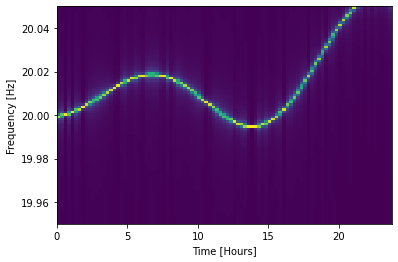

In [15]:
t, f, spec = MakeSpectrogram(f_sig = np.random.uniform(f_sig - 0.5 * bandwidth, f_sig + 0.5 * bandwidth), bandwidth = bandwidth, Tobs_hr = Tobs_hr, Tcoh_hr = T_coh, 
              hnoise = np.random.uniform(0.0, 0.05), hamp = np.random.uniform(0.1, 0.5), fsamp = 128., fdot_sig = fdot_sig, 
              fdotdot_sig=fdotdot_sig, Omega=1e-4, a_p=2, plot_num = 0, plot = True, write_to_file = False)

In [16]:
# 1.0 / (bandwidth / 90)

In [17]:
spec.shape

(90, 96)

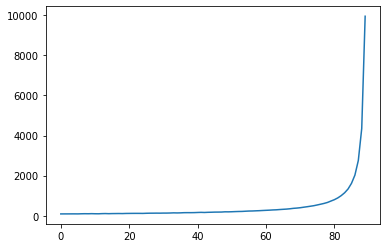

In [18]:
plt.plot(spec[:,-1])

In [19]:
np.random.uniform(-8, -6)

-7.657963425168952

In [20]:
# Max frequency offset in a 24 hour period.

delta_t = T_coh * 3600

freq_resolution = 1.0 / delta_t

fdot_min, fdot_max = 1e-8, 1e-6
fdotdot_min, fdotdot_max = 1e-12, 1e-13




print(delta_t, freq_resolution, fdot_min * (Tobs_hr * 60 * 60) * delta_t, fdot_max * (Tobs_hr * 60 * 60) * delta_t)
print(fdotdot_min * ((Tobs_hr * 60 * 60)**2) * delta_t, fdotdot_max * ((Tobs_hr * 60 * 60)**2) * delta_t)

900.0 0.0011111111111111111 0.7776 77.75999999999999
6.718464 0.6718464000000001


In [21]:
all_specs = []
N = 500



f_lower = fmin + 0.25 * (fmax - fmin)
f_upper = fmin + 0.75 * (fmax - fmin)

f1min, f1max = -8, -6

f2min, f2max = -13, -12

omega_min, omega_max = -10, -5
ap_min, ap_max = 0.0, 2.0

def invert_scaling(x, max_val, min_val):
  return x * (max_val - min_val) + min_val


x_s = []
for i in range(N):
  # t, f, spec = MakeSpectrogram(f_sig = np.random.random() * 100., bandwidth = 0.05, Tobs_hr = 12., Tcoh_hr = .25, 
  #             hnoise = 100. + (1 - 2 * np.random.random() * 10.), hamp = .4, fsamp = 128., fdot_sig = -1e-6, 
  #             plot_num = 0, plot = True, write_to_file = False)
  

  
  freq = np.random.uniform(f_lower, f_upper)
  scaled_freq = (freq - fmin) / (fmax - fmin)

  
  
  spindown_exponent = np.random.uniform(f1min, f1max)
  spindown = 10**spindown_exponent
  scaled_spindown = (spindown_exponent - f1min) / (f1max - f1min)
  
  fdotdot_sign = np.random.choice([-1, 1])
  fdotdot_exponent = np.random.uniform(f2min, f2max)
  fdotdot = fdotdot_sign * 10**fdotdot_exponent
  scaled_fdotdot = fdotdot_sign * (fdotdot_exponent - f2min) / (f2max - f2min)

  omega_exponent = np.random.uniform(omega_min, omega_max)
  omega = 10**omega_exponent
  scaled_omega = (omega_exponent - omega_min) / (omega_max - omega_min)

  a_p = np.random.uniform(ap_min, ap_max)
  scaled_a_p = (a_p - ap_min) / (ap_max - ap_min)

  # print(freq, spindown, fdotdot)

  t, f, spec = MakeSpectrogram(f_sig = freq, bandwidth = bandwidth, Tobs_hr = 12., Tcoh_hr = .25, 
            hnoise = np.random.uniform(0.0, 0.001), hamp = np.random.uniform(0.1, 0.5), fsamp = 128., fdot_sig = spindown, fdotdot_sig = fdotdot,
            Omega=omega, a_p=a_p,
            plot_num = 0, plot = False, write_to_file = False)
  

  freq_start_bin = np.argmax(spec[:,0]) / spec.shape[0]

  # scaler = StandardScaler()
  # spec = scaler.fit_transform(spec)

  r = fix_dims_and_normalize(np.copy(spec))

  # print(r.shape)
  all_specs.append(r)
  x_s.append((scaled_freq, scaled_spindown, scaled_fdotdot, scaled_omega, scaled_a_p, freq_start_bin))

  if (i % 100) == 0:
    print(f"i = {i}")

all_specs = np.asanyarray(all_specs)

size = len(all_specs)

print(all_specs.shape)

i = 0
i = 100
i = 200
i = 300
i = 400
(500, 90, 48)


In [22]:
r, spec.shape

(array([[0.00142951, 0.00104371, 0.00064803, ..., 0.00186659, 0.00231731,
         0.00274106],
        [0.00145439, 0.00106128, 0.00065928, ..., 0.00189745, 0.00235647,
         0.00278686],
        [0.00147952, 0.00108031, 0.00067028, ..., 0.0019305 , 0.00239599,
         0.00283388],
        ...,
        [0.00317128, 0.00231536, 0.00144192, ..., 0.0044281 , 0.00547961,
         0.00650007],
        [0.00305871, 0.00223266, 0.00138973, ..., 0.00426302, 0.00527582,
         0.00625754],
        [0.00295337, 0.00215558, 0.0013415 , ..., 0.00410947, 0.00508557,
         0.0060329 ]]), (90, 48))

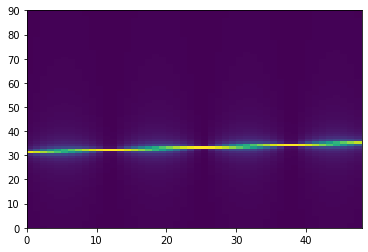

In [23]:
plt.pcolormesh(all_specs[1,:,:])

In [24]:
# x_s

In [25]:
# all_specs

In [26]:
x_s = np.asanyarray(x_s)

x_s.shape

(500, 6)

In [27]:
from sklearn.preprocessing import StandardScaler

In [28]:
# x_scaler = StandardScaler()
# scaled_x_s = x_scaler.fit_transform(x_s)

In [29]:
scaled_x_s = x_s

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
# x_train_s, x_test_s, y_train_s, y_test_s = train_test_split(x_s, all_specs, test_size=0.2, random_state=42)

x_train_s, x_test_s, y_train_s, y_test_s = train_test_split(scaled_x_s, all_specs, test_size=0.2, random_state=42)
x_test_s, x_val_s, y_test_s, y_val_s = train_test_split(x_test_s, y_test_s, test_size=0.5, random_state=26)

x_train_s.shape

(400, 6)

In [32]:
x_train_s = np.expand_dims(x_train_s, -1)
x_test_s = np.expand_dims(x_test_s, -1)
x_val_s = np.expand_dims(x_val_s, -1)

y_train_s = np.expand_dims(y_train_s, -1)
y_test_s = np.expand_dims(y_test_s, -1)
y_val_s = np.expand_dims(y_val_s, -1)

x_train_s.shape

(400, 6, 1)

In [33]:
def convert_to_tensor_utility(x):
    return tf.convert_to_tensor(x, dtype=tf.float32)

 
x_train_s, y_train_s, x_test_s, y_test_s, x_val_s, y_val_s = tuple(map(convert_to_tensor_utility, [x_train_s, y_train_s, x_test_s, y_test_s, x_val_s, y_val_s]))

In [34]:
x_train_s.shape, y_train_s.shape

(TensorShape([400, 6, 1]), TensorShape([400, 90, 48, 1]))

In [35]:
y_train_s.shape, y_test_s.shape, y_val_s.shape

(TensorShape([400, 90, 48, 1]),
 TensorShape([50, 90, 48, 1]),
 TensorShape([50, 90, 48, 1]))

In [36]:
# y_train_s

In [37]:
batch_size = 8

In [38]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_s, y_train_s)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_s, y_test_s)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val_s, y_val_s)).batch(batch_size)

In [39]:
params = dict()

params['z_dim'] = 6
params['n_modes'] = 1
params['n_channels'] = 1
params['ramp_start'] = 10
params['ramp_end'] = 20
params['y_normscale'] = 1.0

params['rand_pars'] = ['frequency', 'fdot', 'fdotdot', 'Omega', 'a_p', 'bin']
params['inf_pars'] = ['frequency', 'fdot', 'fdotdot', 'Omega', 'a_p', 'bin']


In [40]:
def ramp_func(epoch,start,ramp_length, n_cycles):
    i = (epoch - start) / (2.0 * ramp_length)
    # print(epoch,i)
    
    if i < 0:
        return 0.0
    if i >= n_cycles:
        return 1.0
    
    return min(1.0, 2.0 * np.remainder(i, 1.0))

optimizer = tf.keras.optimizers.Adam(1e-4)
initializer = tf.keras.initializers.GlorotUniform()

In [41]:
def define_encoder_block(x, num_filters, act):  
    """
    Todo: Define two sequential 2D convolutional layers (Conv2D) with the following properties:
          - num_filters many filters
          - kernel_size 3
          - activation "relu"
          - padding "same"
          - kernel_initializer "he_normal"
          Also define a 2D max pooling layer (MaxPooling2D) (you can keep default arguments).
    """
    x = tf.keras.layers.Conv2D(num_filters, 4, activation=act, padding='same', kernel_initializer='he_normal')(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(num_filters, 4, activation=act, padding='same', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    
    return x

In [42]:
def define_decoder_block(x, num_filters, act):
    """
    Todo: Define one 2D upsampling layer (UpSampling2D) (you can keep default arguments).
          Also, define two sequential 2D convolutional layers (Conv2D) with the following properties:
          - num_filters many filters
          - kernel_size 3
          - activation "relu"
          - padding "same"
          - kernel_initializer "he_normal"
    """
    x = tf.keras.layers.UpSampling2D()(x)
    x = tf.keras.layers.Conv2DTranspose(num_filters, 4, activation=act, padding = 'same', kernel_initializer = 'he_normal')(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2DTranspose(num_filters, 4, activation=act, padding = 'same', kernel_initializer = 'he_normal')(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    return x

In [77]:
class CVAE(tf.keras.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, x_dim, y_dim, n_channels, z_dim, n_modes, params):
        super(CVAE, self).__init__()
        self.z_dim = z_dim
        self.n_modes = n_modes
        self.x_modes = 1   # hardcoded for testing
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.n_channels = n_channels
        self.act = tf.keras.layers.LeakyReLU(alpha=0.3)
        self.params = params
        self.reg = regularizers.l1(0.25)


        start_filters = 2

        
        # the r1 encoder network- r1_encoder(y) = z'.

        r1_input_y = tf.keras.Input(shape=(WIDTH, HEIGHT, 1))

        eblock1 = define_encoder_block(r1_input_y, start_filters, self.act)
        # eblock2 = define_encoder_block(eblock1, start_filters*2, self.act)
        # eblock3 = define_encoder_block(eblock2, start_filters*4, self.act)
        # eblock4 = define_encoder_block(eblock3, start_filters*8, self.act)
        eblock4 = eblock1
        _, *shape_spatial = eblock4.get_shape().as_list()
        eblock4_flat = tf.keras.layers.Flatten()(eblock4)

        # x = tf.keras.layers.BatchNormalization(name='bn_2')(eblock4_flat)
        # a2 = tf.keras.layers.Dense(16, kernel_regularizer=self.reg, activation=self.act)(x)
        # a2 = tf.keras.layers.Dropout(.1)(a2)
        # a2 = tf.keras.layers.Dense(8, kernel_regularizer=self.reg, activation=self.act)(a2)
        # a2 = tf.keras.layers.Dropout(.1)(a2)
        # a2 = x
        a2 = eblock4_flat
        a2 = tf.keras.layers.Dense(4, kernel_regularizer=self.reg, activation=self.act)(a2)
        # a2 = tf.keras.layers.BatchNormalization()(a2)
        a2 = tf.keras.layers.Dense(2 * self.z_dim, activation=self.act, kernel_regularizer=self.reg)(a2)
        self.encoder_r1 = tf.keras.Model(inputs=r1_input_y, outputs=a2)

        # print(self.encoder_r1.summary())


        # the q encoder network- q_encoder(x, y) = z''.

        q_input_x = tf.keras.Input(shape=(self.x_dim))
        c = tf.keras.layers.Flatten()(q_input_x)
        d = tf.keras.layers.concatenate([eblock4_flat, c])
        # d = tf.keras.layers.BatchNormalization()(d)
        # e = tf.keras.layers.Dense(16, kernel_regularizer=self.reg, activation=self.act)(d)
        # e = tf.keras.layers.Dropout(.1)(e)
        e = d
        e = tf.keras.layers.Dense(4, kernel_regularizer=self.reg, activation=self.act)(e)
        e = tf.keras.layers.BatchNormalization()(e)
        e = tf.keras.layers.Dense(2*self.z_dim, activation=self.act)(e)
        self.encoder_q = tf.keras.Model(inputs=[q_input_x, r1_input_y], outputs=e)


        # print(self.encoder_q.summary())


        # the r2 decoder network- r2_decoder(y, z) = x'.

        r2_input_z = tf.keras.Input(shape=(self.z_dim))
        

        
        h = tf.keras.layers.concatenate([eblock4_flat, r2_input_z])
        # h = tf.keras.layers.BatchNormalization(name='bn_6')(h)
        i = tf.keras.layers.Dense(8, kernel_regularizer=self.reg, activation=self.act)(h)
        # i = tf.keras.layers.Dropout(.5)(i)
        # i = tf.keras.layers.Dense(16, kernel_regularizer=self.reg, activation=self.act)(i)
        # i = tf.keras.layers.BatchNormalization(name='bn_7')(i)
        j = tf.keras.layers.Dense(4, activation=self.act)(i)
        j = tf.keras.layers.Dense(2*self.x_dim)(j)
        self.decoder_r2 = tf.keras.Model(inputs=[r1_input_y, r2_input_z], outputs=j)

        

        print(self.decoder_r2.summary())
        # During use, we would only have y. Use r1_encoder(y) = z'. Then, use r2_decoder(y, z') = x' to get the prediction / posterior.
    
    def get_encoders(self):
        return self.encoder_r1, self.encoder_q
    

    @tf.function
    def sample(self, eps=None):
      if eps is None:
        eps = tf.random.normal(shape=(100, self.z_dim))
      return self.decode(eps, apply_sigmoid=True)

    def encode_r1(self, y):
      mean, logvar = tf.split(self.encoder_r1(y), num_or_size_splits=2, axis=1)
      return mean, logvar

    def encode_q(self, x, y):
      mean, logvar = tf.split(self.encoder_q([x, y]), num_or_size_splits=2, axis=1)
      return mean, logvar

    def reparameterize(self, mean, logvar):
      eps = tf.random.normal(shape=mean.shape)
      return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
      logits = self.decoder(z)
      if apply_sigmoid:
        probs = tf.sigmoid(logits)
        return probs
      return logits


    def decode_r2(self, y=None, z=None, apply_sigmoid=False):
        mean, logvar = tf.split(self.decoder_r2([y, z]), num_or_size_splits=2, axis=1)
        return mean, logvar

In [78]:
tf.random.set_seed(42)
np.random.seed(42)



epochs = 200


ramp_start = 50
ramp_length = 100


ramp_cycles = 1

# start the training loop
train_loss = np.zeros((epochs, 3))
test_loss = np.zeros((epochs, 3))

KL_samples = []



model = CVAE(x_dim=6, y_dim=1, n_channels=params['n_channels'], \
             z_dim=params['z_dim'], n_modes=1, params=params)

model.compile()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 90, 48, 1)]  0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 90, 48, 2)    34          ['input_4[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 90, 48, 2)    66          ['conv2d_2[0][0]']               
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 45, 24, 2)   0           ['conv2d_3[0][0]']               
                                                                                            

In [79]:
from tensorflow.keras.losses import MeanSquaredError

In [80]:
EPS = 1e-6
dist_mask = np.array([True])
not_dist_mask = np.array([True])

bounds = dict(a=0.0, b=30.0)


# KL[P || Q] = S(P) - H(P, Q)               Model P with approximation Q.
# KL[Q || P] = S(Q) - H(Q, P)               Model Q with approximation P.

# Variational Autoencoders:
#  Let X be the data we want to model, z is the latent variable. Pr[X] = distn of data. Pr[z] latent distrn. Pr[X | z] = distrn of generating data | latent variable.
#  We want to infer Pr[z] from Pr[z | X] which is the distrn that projects our data into the latent space.  
#  But we do not know Pr[z | X], so we use a simpler estimate of Qr[z | X].

# KL( Qr[z | X] || Pr[z | X] ) = E{ log( Qr[z | X] ) - log( Pr[z | X] ) } summed up over Qr[z | X]. 
# KL = H(Q, P) - S(Q) = cross-entropy between Q and P - entropy of P => info in just P - info overlap between P and Q => remaining info in P that we missed. 


# Ingredients:
#   - Qr[z | x]
#   - 

# Infer z_mean, z_var from just y.               Use encoder r1._samp            A = Pr[z | y].
# 
# Infer z'_mean', z'_var' from x, y to get z_sample.                        B = Pr[z | x, y] => sample z_samp from q. We later calculate self-entropy of this.
# Use encoder q for this.  Qr[z_sample | x, y]. Calculate self-entropy.
# C = Pr[z_samp | y] = x_samp.
# 
# Pr[z | x, y] is the "real" / actual distribution. So we want self-entropy of that - cross-entropy of that with Pr[z_samp | y].
# What we are doing is that we are looking at how much information we are missing by calculating z_samp using Pr[z | y] instead of the actual distribution
# of Pr[z | x, y]. This gives us our KL divergence, which we want to minimize.


# Decode (z_sample, y) to get a distribution for x. Pr[x | z_samp, y]. Then, calculate the probability of getting x_actual under this distribution (log-likelihood).
# The higher the probability the better it is, which we want to maximize.

# Total Loss = (2) - (1)




# XXXXX
# Calculate self-entropy with Pr[z_samp] from inference of z_mean with y i.e. Pr[z_mean | y].  So entropy of Pr[z | x, y]. 
# This is the real distribution P. We are approximating it with Qr[z | y]. So we want S[ Pr[z | x, y] ] - H[Pr[z|x,y], Pr[z|y]].
# Pr[z_samp] under A / r1.

# 

tfd = tfp.distributions


'''
def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)
'''


def compute_loss(model, x, y, ramp=1.0, noiseamp=1.0):
    # Encode just y first.
    z_given_y_mean, z_given_y_logvar = model.encode_r1(y)

    # Reparameterize.
    z_given_y = model.reparameterize(z_given_y_mean, z_given_y_logvar)

    # Encode x and y to get z.
    zq_given_x_y_mean, zq_given_x_y_logvar = model.encode_q(x, y)

    # Reparameterize.
    zq_given_x_y = model.reparameterize(zq_given_x_y_mean, zq_given_x_y_logvar)      # q 

    
    x_given_y_z = model.decode_r2(y, zq_given_x_y)

    # We want x_given_y_z to be as close to x (input) as possible.
    mse = tf.keras.losses.mse(x_given_y_z[0], x)
    mse = tf.reduce_mean(mse)
    # Now, do KL-divergence.
    
    # We are approximating Pr(z | X) by Qr(z | X), and we want to minimize the distance between the two distributions.
    # KL( Qr[z | X] || Pr[z | X] ) = E{ log( Qr[z | X] ) - log( Pr[z | X] ) } summed up over Qr[z | X].

    # kl_loss = 1 + z_log_var - pz_log_var - K.tf.divide(K.square(z_mean-pz_mean),K.exp(pz_log_var)) - K.tf.divide(K.exp(z_log_var),K.exp(pz_log_var))
    # kl_loss = -0.5*K.sum(kl_loss, axis=-1)

    kl_loss = zq_given_x_y_logvar - z_given_y_logvar + tf.math.divide(tf.math.square(zq_given_x_y_mean - z_given_y_mean), 2 * tf.math.exp(2 * zq_given_x_y_logvar)) \
              + tf.math.divide(tf.math.exp(2 * z_given_y_logvar), 2 * tf.math.exp(2 * zq_given_x_y_logvar))

    kl_loss = tf.reduce_mean(kl_loss)

    return mse, kl_loss

In [81]:
train_loss_metric = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)

@tf.function
def train_step(model, x, y, optimizer, ramp=1.0):
    """Executes one training step and returns the loss.
    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape:
        r_loss, kl_loss = compute_loss(model, x, y, ramp=ramp)
        # r_loss, kl_loss = compute_loss(model, x, y)
        loss = r_loss + ramp * kl_loss
        
    gradients = tape.gradient(loss, model.trainable_variables, unconnected_gradients=tf.UnconnectedGradients.ZERO)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss_metric(loss)
    
    return r_loss, kl_loss, loss

In [82]:


# ramp_list = [ramp_func(ep, ramp_start, ramp_length, ramp_cycles) for ep in np.arange(0, epochs, 1)]

# plt.plot(ramp_list)

In [83]:
x_train_s[1:2,:,0].shape, y_train_s[1:2,:,:,0].shape

(TensorShape([1, 6]), TensorShape([1, 90, 48]))

In [84]:
model.encode_r1(y_train_s[1:2,:,:,0])

(<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
 array([[-0.01542785,  0.03148625,  0.0956341 ,  0.1278049 ,  0.0236148 ,
          0.15516654]], dtype=float32)>,
 <tf.Tensor: shape=(1, 6), dtype=float32, numpy=
 array([[ 0.11679469, -0.04894501,  0.0360241 ,  0.11682863,  0.02532921,
          0.17660046]], dtype=float32)>)

In [85]:
model.encode_q(x_train_s[1:2,:,0], y_train_s[1:2,:,:,0])

(<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
 array([[ 0.05905725, -0.02746127, -0.03521162, -0.05508854,  0.07941642,
          0.10685998]], dtype=float32)>,
 <tf.Tensor: shape=(1, 6), dtype=float32, numpy=
 array([[-0.02081151, -0.01109356, -0.0268687 ,  0.03334036,  0.15880623,
         -0.0466671 ]], dtype=float32)>)

In [86]:
model.decode_r2(y_train_s[1:2,:,:,0], np.random.normal(0, 1, (1, params['z_dim'])))

(<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
 array([[-0.04025345,  0.04958296, -0.03812861, -0.04840943,  0.00443882,
          0.01537558]], dtype=float32)>,
 <tf.Tensor: shape=(1, 6), dtype=float32, numpy=
 array([[-0.02318467, -0.03529839, -0.02199674,  0.01420135,  0.03180993,
          0.07086306]], dtype=float32)>)

In [87]:
x_train_s[1:2,:,0].shape, y_train_s[1:2,:,:,0].shape

(TensorShape([1, 6]), TensorShape([1, 90, 48]))

In [88]:
loss = compute_loss(model, x_train_s[1:2,:,0], y_train_s[1:2,:,:,0])

loss

(<tf.Tensor: shape=(), dtype=float32, numpy=0.46178234>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.52332777>)

In [89]:
tf.get_static_value(loss[0])

0.46178234

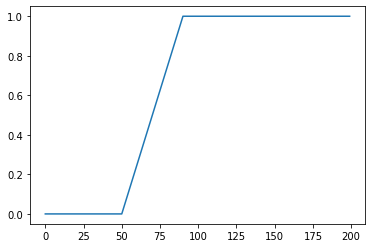

In [90]:
ramp_grad = 0.025

plt.plot([np.min([(epoch-ramp_start)*ramp_grad,1.0]) if epoch > ramp_start else 0.0 for epoch in range(0, epochs, 1)])

In [91]:
loss = tf.keras.metrics.Mean()

print("Running with", epochs, "epochs.")

for epoch in range(1, epochs + 1):
    temp_train_r_loss, temp_train_kl_loss, temp_train_loss = 0.0, 0.0, 0.0
    temp_test_r_loss, temp_test_kl_loss, temp_test_loss = 0.0, 0.0, 0.0

    
    
    current_ramp = (np.min([(epoch-ramp_start)*ramp_grad,1.0]).astype(np.single) if epoch>ramp_start else 0.0)
    

    # current_ramp = 1.0
    # print(ramp)
    
    for step, (x_batch_train, y_batch_train) in train_dataset.enumerate():
        x_b = x_batch_train[:,:,0]
        # print("x_batch, y_batch", x_b.shape, y_batch_train.shape)    
        temp_train_r_loss, temp_train_kl_loss, temp_train_loss = train_step(model, x_b, y_batch_train, optimizer, ramp=current_ramp)

        # print(temp_train_r_loss, temp_train_kl_loss, temp_train_loss)
        
        train_loss[epoch - 1, 0] += temp_train_r_loss / len(train_dataset)
        train_loss[epoch - 1, 1] += temp_train_kl_loss / len(train_dataset)
        train_loss[epoch - 1, 2] += temp_train_loss / len(train_dataset)
        
    for step, (x_batch_test, y_batch_test) in test_dataset.enumerate():
        x_b_t = x_batch_test[:,:,0]
        temp_test_r_loss, temp_test_kl_loss = compute_loss(model, x_b_t, y_batch_test)
        test_loss[epoch - 1, 0] += temp_test_r_loss / len(test_dataset)
        test_loss[epoch - 1, 1] += temp_test_kl_loss / len(test_dataset)
        # test_loss[epoch - 1, 2] += temp_test_loss / len(test_dataset)
    
    if epoch % 10 == 0:
        print("epoch = %d; train loss = %.4e, train KL = %.4e; train total: %.4e; test loss = %.4e, test KL = %.4e" % \
              (epoch, tf.get_static_value(train_loss[epoch - 1, 0]), tf.get_static_value(train_loss[epoch - 1, 1]), tf.get_static_value(train_loss[epoch - 1, 2]), \
               tf.get_static_value(test_loss[epoch - 1, 0]), tf.get_static_value(test_loss[epoch - 1, 1])))


Running with 200 epochs.
epoch = 10; train loss = 8.4798e-02, train KL = 9.1363e-01; train total: 8.4798e-02; test loss = 9.5646e-02, test KL = 9.2196e-01
epoch = 20; train loss = 7.4933e-02, train KL = 1.1224e+00; train total: 7.4933e-02; test loss = 9.1727e-02, test KL = 1.1110e+00
epoch = 30; train loss = 6.8336e-02, train KL = 1.4718e+00; train total: 6.8336e-02; test loss = 9.1137e-02, test KL = 1.4506e+00
epoch = 40; train loss = 5.9981e-02, train KL = 2.0322e+00; train total: 5.9981e-02; test loss = 8.6467e-02, test KL = 1.9849e+00
epoch = 50; train loss = 5.4399e-02, train KL = 2.7979e+00; train total: 5.4399e-02; test loss = 8.7062e-02, test KL = 2.7087e+00
epoch = 60; train loss = 5.8719e-02, train KL = 5.1710e-01; train total: 1.8799e-01; test loss = 1.0484e-01, test KL = 5.1410e-01
epoch = 70; train loss = 5.5982e-02, train KL = 5.0491e-01; train total: 3.0843e-01; test loss = 1.0639e-01, test KL = 5.0609e-01
epoch = 80; train loss = 5.3545e-02, train KL = 5.0238e-01; train

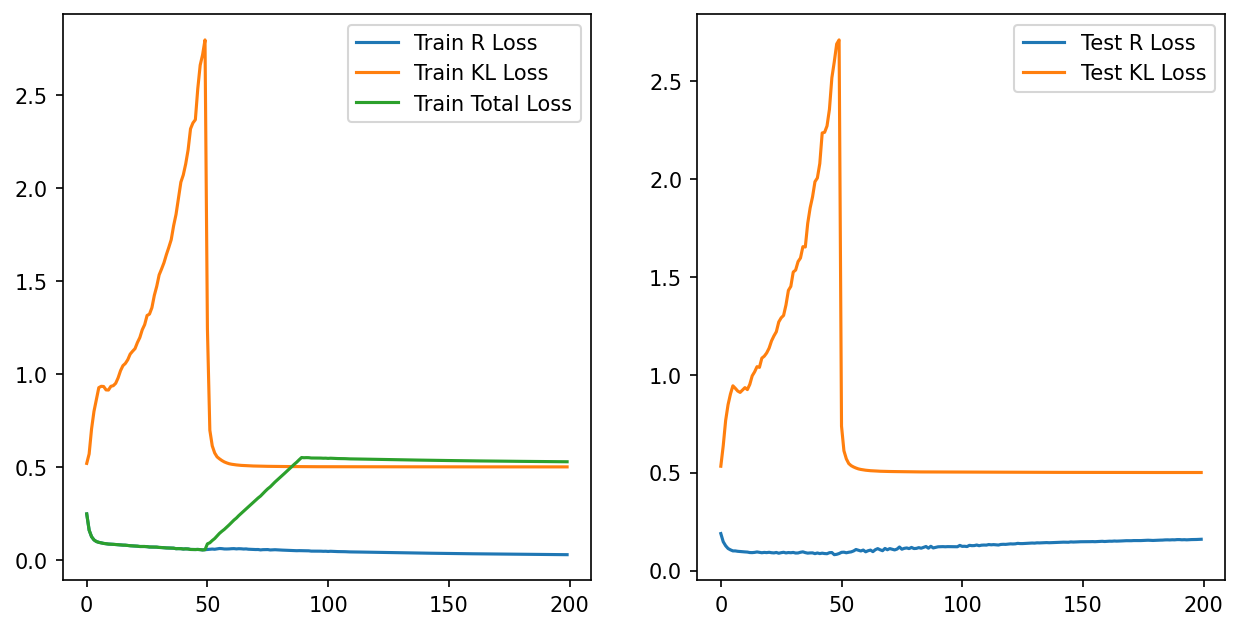

In [92]:
plt.figure(figsize=(10, 5), dpi=150)

plt.subplot(121)
plt.plot(train_loss[:,0], label="Train R Loss")
# plt.plot(test_loss[:,0], label="Test R Loss")
plt.plot(train_loss[:,1], label="Train KL Loss")
plt.plot(train_loss[:,2], label="Train Total Loss")

# plt.ylim(0, 0.1)

plt.legend()
# plt.yscale('log')

plt.subplot(122)
plt.plot(test_loss[:,0], label="Test R Loss")
plt.plot(test_loss[:,1], label="Test KL Loss")

# plt.ylim(0, 0.15)

plt.legend()
# plt.yscale('log')

In [93]:
def gen_z_samples(model, x, y, nsamples=1000):
    
    y = y / params['y_normscale']
    y = tf.tile(y,(nsamples, 1, 1))
    x = tf.tile(x,(nsamples, 1))
    
    mean_r1, logvar_r1, logweight_r1 = model.encode_r1(y=y)
    
    scale_r1 = EPS + tf.sqrt(tf.exp(logvar_r1))
    
    gm_r1 = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(logits=logweight_r1),
            components_distribution=tfd.MultivariateNormalDiag(
            loc=mean_r1,
            scale_diag=scale_r1))
    
    z_samp_r1 = gm_r1.sample()
    
    mean_q, logvar_q = model.encode_q(x=x,y=y)
    
    scale_q = EPS + tf.sqrt(tf.exp(logvar_q))
    mvn_q = tfp.distributions.MultivariateNormalDiag(
                          loc=mean_q,
                          scale_diag=scale_q)
    
    z_samp_q = mvn_q.sample()    
    
    return mean_r1, z_samp_r1, mean_q, z_samp_q

In [94]:
def gen_samples(model, y, ramp=1.0, nsamples=100, max_samples=10):    # Generate samples from (test) y.

    y = y
    y = tf.tile(y, (max_samples, 1, 1, 1))
    
    samp_iterations = int(nsamples / max_samples)

    print("samp_iterations", samp_iterations)
    
    x_sample = []
    for i in range(samp_iterations):
        mean_r1, logvar_r1 = model.encode_r1(y=y) # Encode y to get z.
        
        

        
        # z_samp = gm_r1.sample()   # Sample a z_samp.

        z_samp = model.reparameterize(mean_r1, logvar_r1)
        
        mean_r2, logvar_r2 = model.decode_r2(z=z_samp,y=y)  # Decode (z_samp, y) => x

        current_sample = model.reparameterize(mean_r2, logvar_r2)
        # current_sample_inverse_transformed = x_scaler.inverse_transform(current_sample)

        if i == 0:
            x_sample = current_sample   # Sample an x.
        else:
            x_sample = tf.concat([x_sample, current_sample],axis=0)


    return np.array(x_sample)


In [95]:
bounds = {'frequency_min': fmin, 'frequency_max': fmax}

defaults_kwargs = dict(
                    bins=50, smooth=0.9, label_kwargs=dict(fontsize=16),
                    title_kwargs=dict(fontsize=16), quantiles=[0.16, 0.84],
                    levels=(0.68,0.90,0.95), density=True,
                    plot_density=False, plot_datapoints=True,
                    max_n_ticks=5)


hist_kwargs = dict(density=True)
hist_kwargs_other = dict(density=True)

In [96]:
plot_dir = "./"
params['n_samples'] = 1000

run = plot_dir

In [97]:
params['corner_labels'] = {'frequency': 'frequency', 'fdot': 'fdot', 'fdotdot': 'fdotdot', 'Omega': 'Omega', 'a_p': 'a_p', 'bin': 'bin'}

In [98]:
# invert_scaling(x, max_value, min_value)

min_max_values = [(fmin, fmax), (f1min, f1max), (f2min, f2max), (omega_min, omega_max), (ap_min, ap_max), (0, 90)]

min_max_values

[(19.95, 20.05), (-8, -6), (-13, -12), (-10, -5), (0.0, 2.0), (0, 90)]

In [99]:
def generate_posterior(dataset):

  for step, (x_batch, y_batch) in dataset.enumerate():

      if step > 1:
        break

      samples = gen_samples(model, y_batch, ramp=1.0, nsamples=params['n_samples'], max_samples=100)

      print('Epoch: {}, run {} Testing time elapsed for {} samples.'.format(epoch, run, params['n_samples']))

      # print(np.mean(samples), np.mean(x_truth))
      # print(samples)

      # x_truth = x_scaler.inverse_transform(x_batch)
      # x_truth = np.expand_dims(x_scaler.inverse_transform(x_batch[:,:,0]), -1)

      # x_batch[:,:-1]
      x_truth = x_batch    # Exclude the very last parameter

      # tf.reduce_mean(x_truth[:,:,0], axis=(0))

      sample_mean = tf.math.reduce_mean(samples, axis=0)
      sample_std = tf.math.reduce_std(samples, axis=0)
      x_truth_mean = tf.math.reduce_mean(x_truth[:,:,0], axis=0)
      x_truth_std = tf.math.reduce_std(x_truth[:,:,0], axis=0)

      # print(type(sample_mean), type(x_truth_mean))
      # diff = 100 * np.abs(sample_mean - x_truth_mean) / x_truth_mean
      diff = -1

      # print("Mean of sample = %.2f (%.2f); mean of truth = %.2f (%.2f); difference = %.2f percent." % (sample_mean, sample_std, x_truth_mean, x_truth_std, diff))
      
      # print("Mean of sample = ", end="\t")
      # print(sample_mean)
      # print(" x truth mean = ", end="\t")
      # print(x_truth_mean)
      # print(" diff = ", end="\t")
      # print(diff)
      

      # print(params['corner_labels'])
      # Get corner parnames to use in plotting labels
      parnames = []
      for k_idx, k in enumerate(params['rand_pars']):
          # print(k_idx, k)
          if np.isin(k, params['inf_pars']):
              parnames.append(params['corner_labels'][k])

      full_true_x = np.zeros(x_truth.shape[1:])
      new_samples = np.zeros([samples.shape[0], len(params['inf_pars'])])

      # print(full_true_x.shape)
      # print(x_truth[0].shape)
      for inf_par_idx, inf_par in enumerate(params['inf_pars']):
        min_max_value = min_max_values[inf_par_idx]
        # print(inf_par_idx)
        new_samples[:,inf_par_idx] = invert_scaling(samples[:,inf_par_idx], min_max_value[0], min_max_value[1])
        # print(min_max_value)
        # print(new_samples[:,inf_par_idx][0:5])
        # break
        full_true_x[inf_par_idx] = invert_scaling(x_truth[0, inf_par_idx, 0], min_max_value[0], min_max_value[1])
      
      # print("Full true x = ", full_true_x[:,0])
      # plt.subplot(width, height, step + 1)
      # figure = corner.corner(new_samples, **defaults_kwargs,labels=parnames,
      #                   color='tab:red',
      #                   fill_contours=True, truths=full_true_x[:,0],
      #                   show_titles=True, hist_kwargs=hist_kwargs)

      figure = corner.corner(new_samples, 
                             labels=parnames, 
                             **defaults_kwargs,
                             fill_contours=True,
                             show_titles=True,
                             hist_kwargs=hist_kwargs
                             )
      
      figure.suptitle(" ".join([f"{t:.2f}" for t in full_true_x[:,0]]))

      value1 = full_true_x[:,0]
      value2 = np.mean(new_samples, axis=0)

      ndim = len(params['inf_pars'])
      # Extract the axes
      axes = np.array(figure.axes).reshape((ndim, ndim))

      # Loop over the diagonal
      for i in range(ndim):
          ax = axes[i, i]
          ax.axvline(value1[i], color="g")
          ax.axvline(value2[i], color="r")

          min_max_value = min_max_values[i]
          ax.set_xlim(min_max_value[0], min_max_value[1])

      # Loop over the histograms
      for yi in range(ndim):
          for xi in range(yi):
              ax = axes[yi, xi]
              ax.axvline(value1[xi], color="g")
              ax.axvline(value2[xi], color="r")
              ax.axhline(value1[yi], color="g")
              ax.axhline(value2[yi], color="r")
              ax.plot(value1[xi], value1[yi], "sg")
              ax.plot(value2[xi], value2[yi], "sr")

              min_max_value_for_x = min_max_values[xi]
              min_max_value_for_y = min_max_values[yi]

              ax.set_xlim(min_max_value_for_x[0], min_max_value_for_x[1])
              ax.set_ylim(min_max_value_for_y[0], min_max_value_for_y[1])
              
      figure.set_tight_layout(True)

      break

samp_iterations 10
Epoch: 200, run ./ Testing time elapsed for 1000 samples.


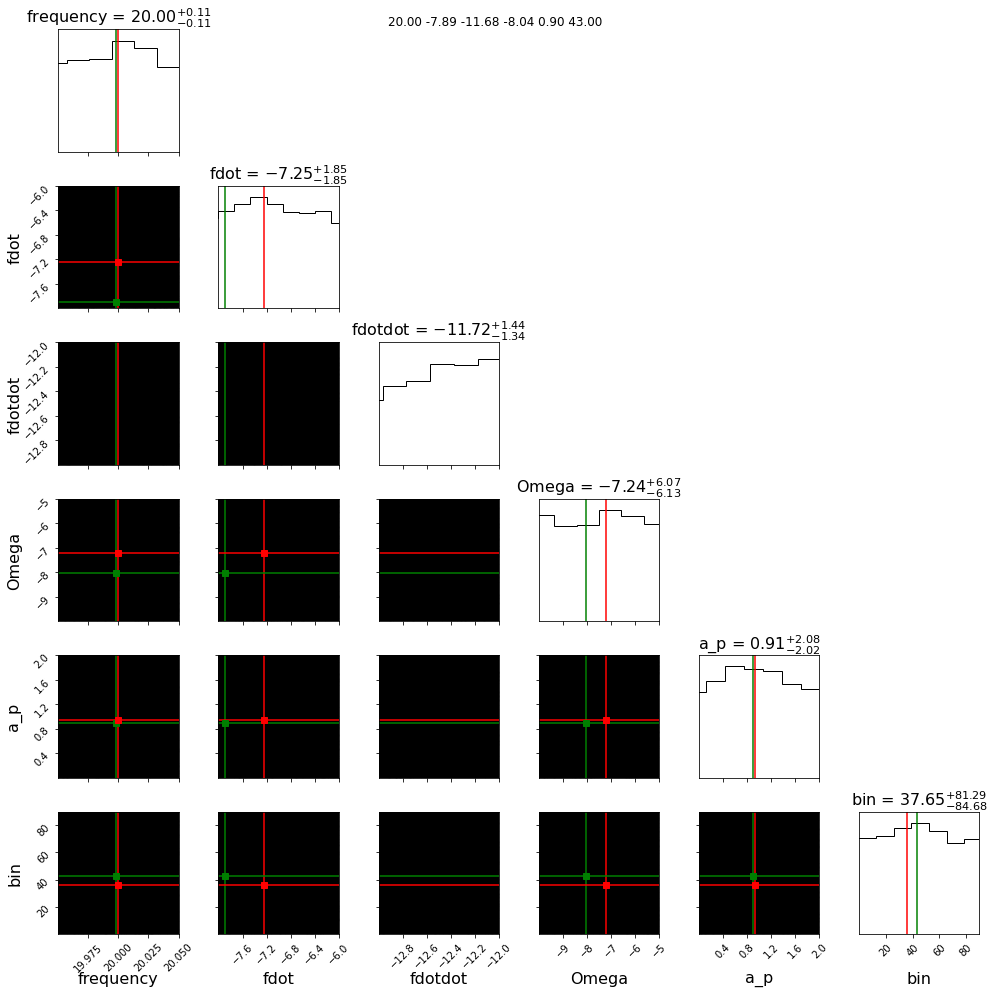

In [100]:
generate_posterior(train_dataset)

In [101]:
params['inf_pars']

ListWrapper(['frequency', 'fdot', 'fdotdot', 'Omega', 'a_p', 'bin'])

samp_iterations 10
Epoch: 200, run ./ Testing time elapsed for 1000 samples.


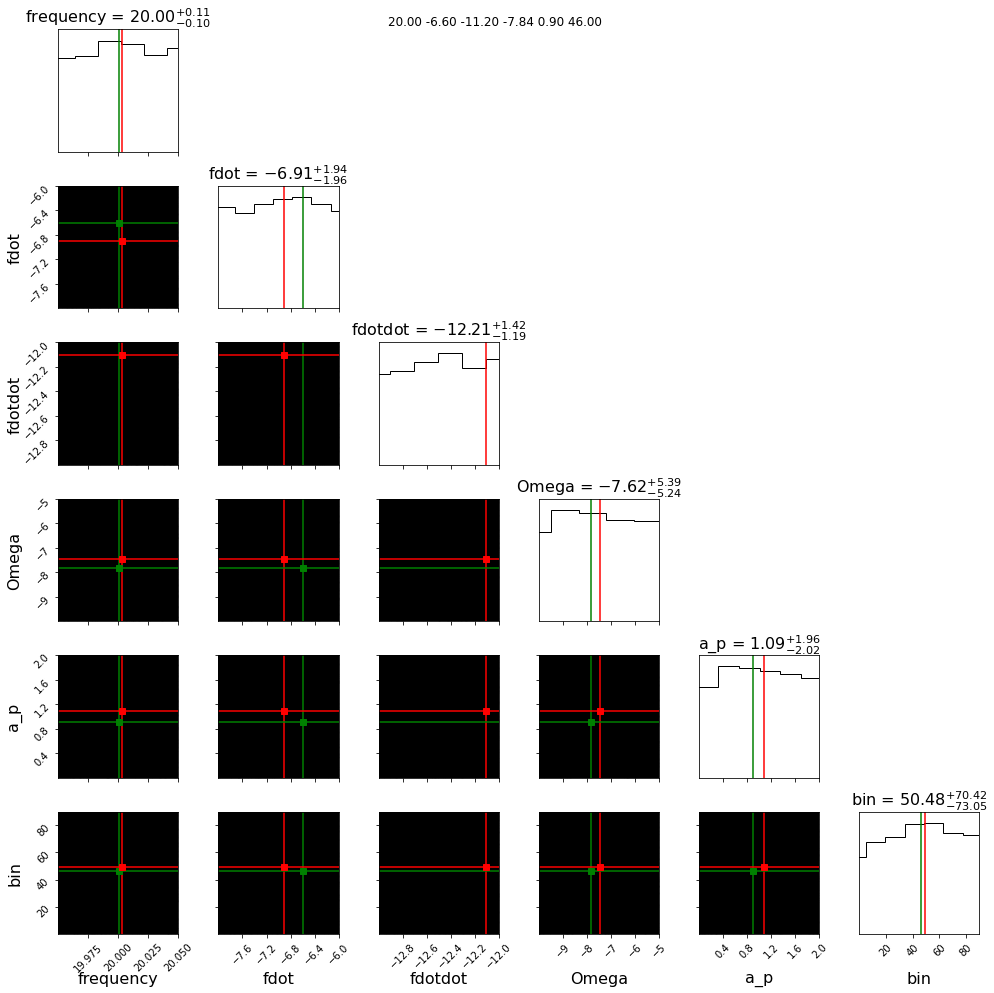

In [102]:
generate_posterior(test_dataset)

In [103]:
x_s.shape

(500, 6)

In [104]:
for step, (x_batch, y_batch) in train_dataset.enumerate():

  print(x_batch.shape)
  print(x_batch[:,0,:])

(8, 6, 1)
tf.Tensor(
[[0.521286  ]
 [0.49874088]
 [0.449305  ]
 [0.7352557 ]
 [0.3572423 ]
 [0.5801759 ]
 [0.7071914 ]
 [0.54725754]], shape=(8, 1), dtype=float32)
(8, 6, 1)
tf.Tensor(
[[0.48574692]
 [0.3538642 ]
 [0.2906035 ]
 [0.28351116]
 [0.3461567 ]
 [0.65168154]
 [0.3207238 ]
 [0.7204987 ]], shape=(8, 1), dtype=float32)
(8, 6, 1)
tf.Tensor(
[[0.46102953]
 [0.52609056]
 [0.36763585]
 [0.6551914 ]
 [0.34205496]
 [0.2935481 ]
 [0.70688033]
 [0.25318545]], shape=(8, 1), dtype=float32)
(8, 6, 1)
tf.Tensor(
[[0.49705607]
 [0.514427  ]
 [0.47010607]
 [0.48866662]
 [0.3547003 ]
 [0.41379482]
 [0.49473813]
 [0.28165087]], shape=(8, 1), dtype=float32)
(8, 6, 1)
tf.Tensor(
[[0.6453314 ]
 [0.73758346]
 [0.64707357]
 [0.3782568 ]
 [0.6755241 ]
 [0.5272345 ]
 [0.4618438 ]
 [0.6870201 ]], shape=(8, 1), dtype=float32)
(8, 6, 1)
tf.Tensor(
[[0.3812075 ]
 [0.3020892 ]
 [0.29064062]
 [0.60753113]
 [0.2542567 ]
 [0.6237982 ]
 [0.28681177]
 [0.3487197 ]], shape=(8, 1), dtype=float32)
(8, 6, 1)
tf.Ten

In [105]:
min_max_values

[(19.95, 20.05), (-8, -6), (-13, -12), (-10, -5), (0.0, 2.0), (0, 90)]

In [106]:
y_test_s[0,:,:,0].shape

TensorShape([90, 48])

In [107]:
# samples = gen_samples(model, y_test_s, ramp=ramp, nsamples=params['n_samples'])

In [108]:
x_s.shape

(500, 6)

In [109]:
x_test_s[0,:,0]

<tf.Tensor: shape=(6,), dtype=float32, numpy=
array([ 0.49387065,  0.30026686, -0.8044004 ,  0.56740624,  0.5479027 ,
        0.4888889 ], dtype=float32)>

In [110]:
x_mean, x_var = x_scaler.mean_, x_scaler.var_

NameError: ignored

In [ ]:
x_test_s[0,:,0] * np.sqrt(x_var) + x_mean

In [ ]:
plt.pcolormesh(y_test_s[0,:,:,0])

In [ ]:
samples = gen_samples(model, tf.expand_dims(y_test_s[0], axis=0), ramp=ramp, nsamples=200)

In [ ]:
import seaborn as sns

In [ ]:
sns.distplot(samples[:,0])

In [ ]:
import corner
import numpy as np

ndim, nsamples = 4, 50000
np.random.seed(1234)
data1 = np.random.randn(ndim * 4 * nsamples // 5).reshape(
    [4 * nsamples // 5, ndim]
)
mean = 4 * np.random.rand(ndim)
data2 = mean[None, :] + np.random.randn(ndim * nsamples // 5).reshape(
    [nsamples // 5, ndim]
)
samples = np.vstack([data1, data2])

# figure = corner.corner(samples)


In [ ]:
# This is the true mean of the second mode that we used above:
value1 = mean

# This is the empirical mean of the sample:
value2 = np.mean(samples, axis=0)

# Make the base corner plot
figure = corner.corner(samples)

# Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))

# Loop over the diagonal
for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(value1[i], color="g")
    ax.axvline(value2[i], color="r")

# Loop over the histograms
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(value1[xi], color="g")
        ax.axvline(value2[xi], color="r")
        ax.axhline(value1[yi], color="g")
        ax.axhline(value2[yi], color="r")
        ax.plot(value1[xi], value1[yi], "sg")
        ax.plot(value2[xi], value2[yi], "sr")

        ax.set_xlim(-10, 10)

In [ ]:
encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(24 + 24),
        ]
    )


In [ ]:
decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(24,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )


In [ ]:
encoder.summary()

In [ ]:
decoder.summary()